In [32]:
import pandas as pd
import netCDF4 
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
from copulas.multivariate import GaussianMultivariate
from copulas.multivariate import VineCopula
from copulas.visualization import compare_3d
from copulas.visualization import scatter_3d
from sklearn.preprocessing import MinMaxScaler
from copulas.univariate import GaussianUnivariate
import copulas.bivariate


# Import data

In [57]:
import cdsapi

dataset = "sis-ecde-climate-indicators"
request = {
    "variable": ["hot_days"],
    "origin": "reanalysis",
    "temporal_aggregation": ["monthly"],
    "spatial_aggregation": "gridded",
    "other_parameters": ["35_c"]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-04-20 23:40:03,557 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-20 23:40:03,557 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-20 23:40:04,171 INFO Request ID is 2e96ffc0-bdf1-47eb-97cc-16a01159ebed
2025-04-20 23:40:04,237 INFO status has been updated to accepted
2025-04-20 23:40:37,569 INFO status has been updated to running
2025-04-20 23:40:54,730 INFO status has been updated to successful


'd73c2065edfc1d8d88fec4d0816716d8.zip'

In [ ]:
import cdsapi

dataset = "sis-ecde-climate-indicators"
request = {
    "variable": [
        "extreme_wind_speed_days"
    ],
    "origin": "reanalysis",
    "temporal_aggregation": ["monthly"],
    "spatial_aggregation": "gridded"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-04-20 23:12:13,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-20 23:12:13,405 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-20 23:12:13,566 INFO Request ID is ca4145d4-30e2-4392-b50f-2eb7586a5864
2025-04-20 23:12:13,813 INFO status has been updated to accepted
2025-04-20 23:12:27,943 INFO status has been updated to running
2025-04-20 23:13:30,119 INFO status has been updated to successful


'7f00d90ce047b84a75cf6cb157976c9a.zip'

In [147]:
import cdsapi

dataset = "sis-ecde-climate-indicators"
request = {
    "variable": ["consecutive_dry_days"],
    "origin": "reanalysis",
    "temporal_aggregation": ["monthly"],
    "spatial_aggregation": "gridded"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-04-20 23:24:09,893 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-20 23:24:09,893 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-20 23:24:10,213 INFO Request ID is 44e5229f-16e9-40db-8028-67055afa0a49
2025-04-20 23:24:10,662 INFO status has been updated to accepted
2025-04-20 23:24:24,518 INFO status has been updated to running
2025-04-20 23:25:01,216 INFO status has been updated to successful


'3a3096e36fe10616f37471d150ce6e2.zip'

In [117]:
import cdsapi

dataset = "sis-ecde-climate-indicators"
request = {
    "variable": ["mean_wind_speed"],
    "origin": "reanalysis",
    "temporal_aggregation": ["monthly"],
    "spatial_aggregation": "gridded"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-04-21 00:34:58,540 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-21 00:34:58,540 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-21 00:34:58,735 INFO Request ID is e7a0910f-12f9-4f74-936f-a8485f3ca7a9
2025-04-21 00:34:58,819 INFO status has been updated to accepted
2025-04-21 00:35:07,687 INFO status has been updated to running
2025-04-21 00:35:20,481 INFO status has been updated to successful


'dae158ad542cc8f50f3cb0cca33806c.zip'

# Explore

In [6]:
data_folder = "data"
netcdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")]

In [7]:
netcdf_files

['data\\01_mean_temperature-reanalysis-monthly-grid-1940-2023-v1.0.nc',
 'data\\06_hot_days-reanalysis-monthly-30deg-grid-1940-2023-v1.0.nc',
 'data\\06_hot_days-reanalysis-monthly-35deg-grid-1940-2023-v1.0.nc',
 'data\\18_consecutive_dry_days-reanalysis-monthly-grid-1940-2023-v1.0.nc',
 'data\\24_extreme_wind_speed_days-reanalysis-monthly-grid-1940-2023-v1.0.nc']

In [8]:
import xarray as xr
dry= xr.open_dataset("data\\18_consecutive_dry_days-reanalysis-monthly-grid-1940-2023-v1.0.nc")
hot= xr.open_dataset("data\\06_hot_days-reanalysis-monthly-35deg-grid-1940-2023-v1.0.nc")
wind= xr.open_dataset("data\\24_extreme_wind_speed_days-reanalysis-monthly-grid-1940-2023-v1.0.nc")



In [ ]:
hot


In [10]:
# 1. Moyenne temporelle du nombre de hot days
hot_mean = hot['t2m'].mean(dim='time')


# 3. Convertir en DataFrame
hot_mean_df = hot_mean.to_dataframe().reset_index()

# 4. Sélectionner les 5 plus grandes moyennes
top5 = hot_mean_df.nlargest(10, 't2m')

print(top5)


      lat   lon  realization        t2m
100  26.5  3.00            0  14.963294
95   26.5  1.75            0  14.959325
98   26.5  2.50            0  14.939484
97   26.5  2.25            0  14.938492
96   26.5  2.00            0  14.904762
99   26.5  2.75            0  14.893849
94   26.5  1.50            0  14.862103
101  26.5  3.25            0  14.777778
93   26.5  1.25            0  14.667659
102  26.5  3.50            0  14.600198


In [11]:
# 1. Moyenne temporelle du nombre de hot days
hot_mean = hot['t2m'].mean(dim='time')


# 3. Convertir en DataFrame
hot_mean_df = hot_mean.to_dataframe().reset_index()

# 4. Sélectionner les 5 plus grandes moyennes
top5 = hot_mean_df[(hot_mean_df["lat"]>43) & (hot_mean_df["lon"]<8 )].nlargest(10, 't2m')

print(top5)


         lat   lon  realization       t2m
18806  43.75  4.75            0  0.471230
19055  44.00 -0.75            0  0.455357
19326  44.25 -0.75            0  0.366071
19056  44.00 -0.50            0  0.365079
19077  44.00  4.75            0  0.364087
19076  44.00  4.50            0  0.340278
19597  44.50 -0.75            0  0.333333
19348  44.25  4.75            0  0.322421
19057  44.00 -0.25            0  0.316468
19327  44.25 -0.50            0  0.312500


In [48]:
lat_sel = 26.5
lon_sel = 3
# lat_sel = 44
# lon_sel = -0.75

dry_data = dry['cdd']
hot_data = hot['t2m']
wind_data = wind['data']

# Fusionner les datasets sur les dimensions communes (time, lat, lon)
combined = xr.merge([dry_data.rename('dry'), 
                     hot_data.rename('hot'), 
                     wind_data.rename('wind')])


# Extraire les données pour cette localisation (utilise l'indexation la plus proche)
location_data = combined.sel(lat=lat_sel, lon=lon_sel, method="nearest")

# Convertir en DataFrame avec les années comme index
df = location_data.to_dataframe().reset_index()

# Garde uniquement les colonnes qui nous intéressent
df = df[['time', 'dry', 'hot', 'wind']]

# Optionnel : convertir 'time' en année si tu préfères
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df = df.drop(columns='time')

# Réorganiser les colonnes
df = df[['year', "month", 'dry', 'hot', 'wind']]


In [49]:
df.head(1)

,year,month,dry,hot,wind
0,1940,1,31.0,0,0


In [ ]:
df.groupby("hot").count()

In [50]:
def uniformize_data(df, columns):
    """
    Transforme chaque colonne du DataFrame en pseudo-observations uniformes [0,1]
    Utilisé pour ajuster une copule.

    Args:
        df (pd.DataFrame): DataFrame contenant les colonnes à transformer.
        columns (list): Liste des noms de colonnes à transformer.

    Returns:
        np.ndarray: Tableau numpy transformé (n, d)
    """
    n = len(df)
    u = np.zeros((n, len(columns)))

    for i, col in enumerate(columns):
        ranks = df[col].rank(method='average')  # méthode 'average' pour être stable
        u[:, i] = ranks / (n + 1)  # normalisation sur [0,1]

    return u

# Exemple d’utilisation :
columns = ['dry', 'hot', 'wind']
df_normalized =pd.DataFrame(uniformize_data(df, columns), columns=columns)


In [51]:
df_normalized

,dry,hot,wind
0,0.750743,0.159564,0.311695
1,0.190287,0.159564,0.311695
2,0.750743,0.159564,0.311695
3,0.352329,0.432607,0.311695
4,0.750743,0.614470,0.311695
...,...,...,...
1003,0.750743,0.910803,0.311695
1004,0.352329,0.756194,0.311695
1005,0.750743,0.910803,0.311695
1006,0.352329,0.443508,0.311695


# Copule bivariés

In [47]:
## Landes

## Landes

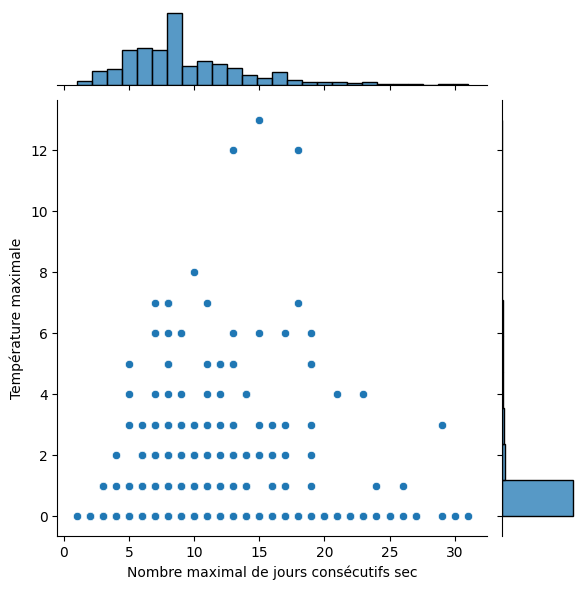

In [ ]:
h = sns.jointplot(x=df.dry, y=df.hot, kind="scatter")
h.set_axis_labels(f"Nombre maximal de jours consécutifs sec, Landes", f"Température maximale, Landes", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


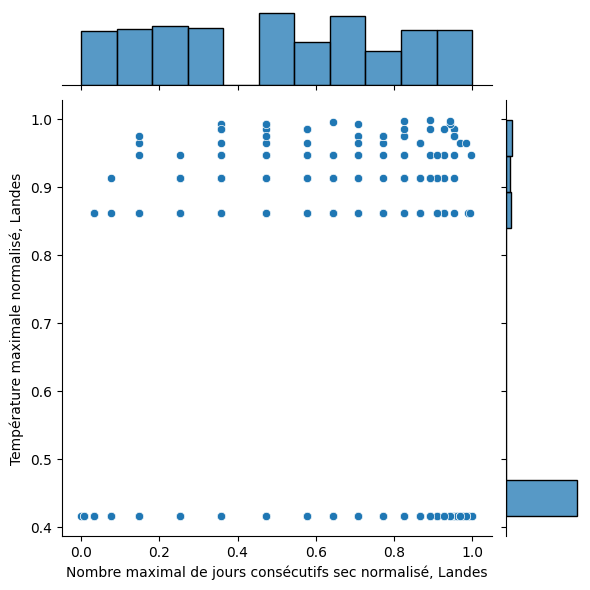

In [26]:
h = sns.jointplot(x=df_normalized.dry, y=df_normalized.hot, kind="scatter")
h.set_axis_labels(f"Nombre maximal de jours consécutifs sec normalisé, Landes", f"Température maximale normalisé, Landes", fontsize=10)
# h2.savefig(f"output/distribution_jointe_normalisé_{self.nom_variable1}_{self.nom_variable2}.png")


In [44]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["dry","hot"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
1.2091024477608039
0.376772779131583


c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


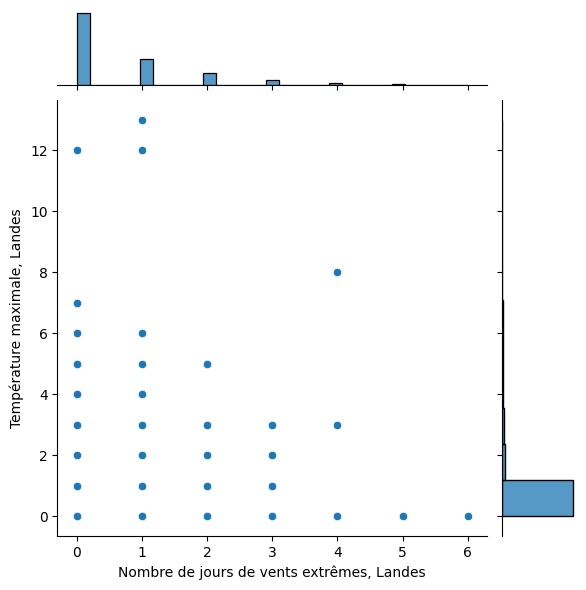

In [27]:
h = sns.jointplot(x=df.wind, y=df.hot, kind="scatter")
h.set_axis_labels(f"Nombre de jours de vents extrêmes, Landes", f"Température maximale, Landes", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


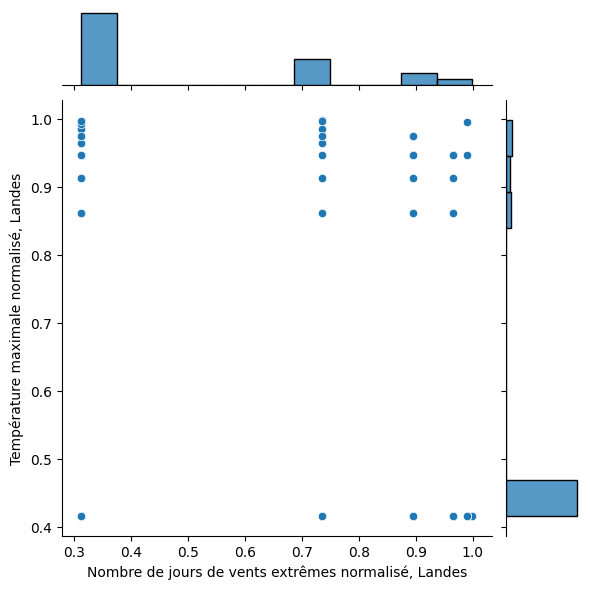

In [28]:
h = sns.jointplot(x=df_normalized.wind, y=df_normalized.hot, kind="scatter")
h.set_axis_labels(f"Nombre de jours de vents extrêmes normalisé, Landes", f"Température maximale normalisé, Landes", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


In [45]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["wind","hot"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

CLAYTON
0.06083065302236485
0.029517540867878726


c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


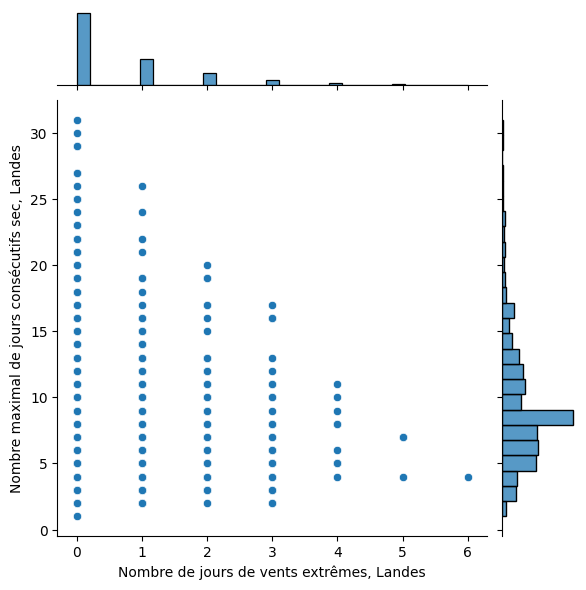

In [29]:
h = sns.jointplot(x=df.wind, y=df.dry, kind="scatter")
h.set_axis_labels(f"Nombre de jours de vents extrêmes, Landes", f"Nombre maximal de jours consécutifs sec, Landes", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


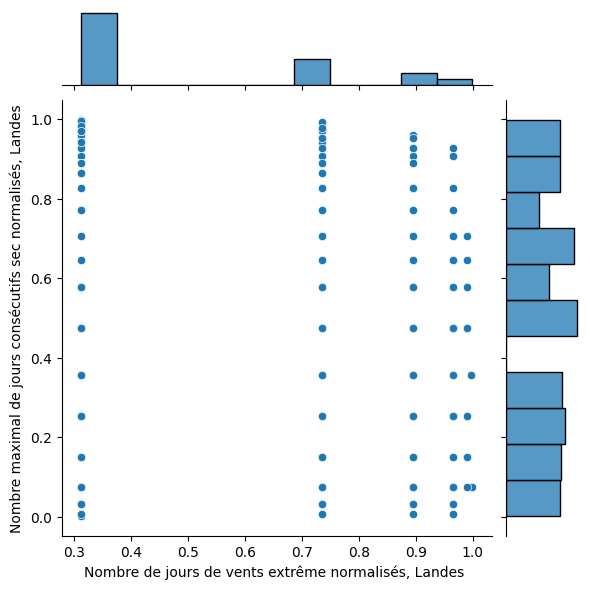

In [30]:
h = sns.jointplot(x=df_normalized.wind, y=df_normalized.dry, kind="scatter")
h.set_axis_labels(f"Nombre de jours de vents extrême normalisés, Landes ", f"Nombre maximal de jours consécutifs sec normalisés, Landes", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


In [46]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["wind","dry"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
-1.5485453733186951
-3.430124051894719


c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


## Arabie Saoudite

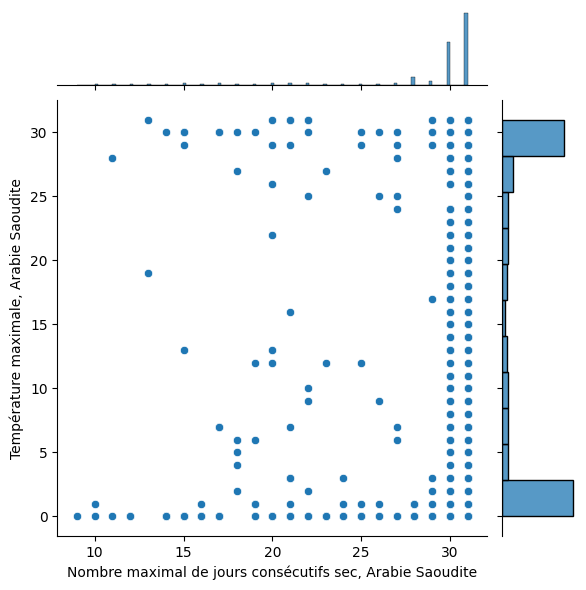

In [52]:
h = sns.jointplot(x=df.dry, y=df.hot, kind="scatter")
h.set_axis_labels(f"Nombre maximal de jours consécutifs sec, Arabie Saoudite", f"Température maximale, Arabie Saoudite", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


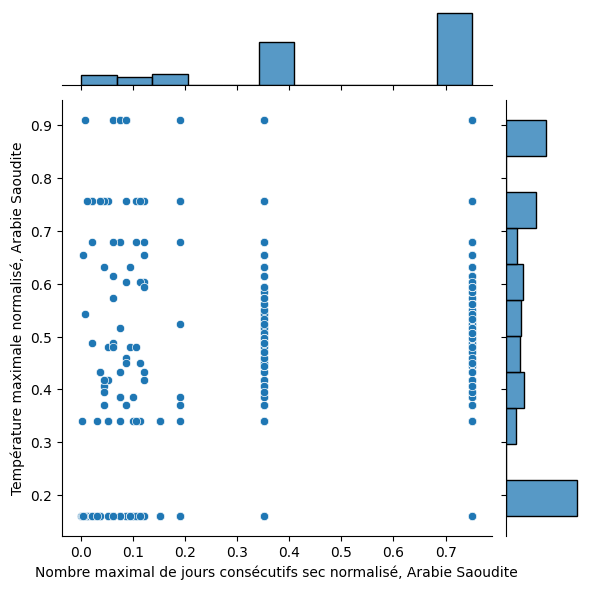

In [53]:
h = sns.jointplot(x=df_normalized.dry, y=df_normalized.hot, kind="scatter")
h.set_axis_labels(f"Nombre maximal de jours consécutifs sec normalisé, Arabie Saoudite", f"Température maximale normalisé, Arabie Saoudite", fontsize=10)
# h2.savefig(f"output/distribution_jointe_normalisé_{self.nom_variable1}_{self.nom_variable2}.png")


In [73]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["dry","hot"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

CLAYTON
0.5459396267841699
0.21443541749407377


c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


C:\Users\lucas\AppData\Local\Temp\ipykernel_50872\3099913191.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


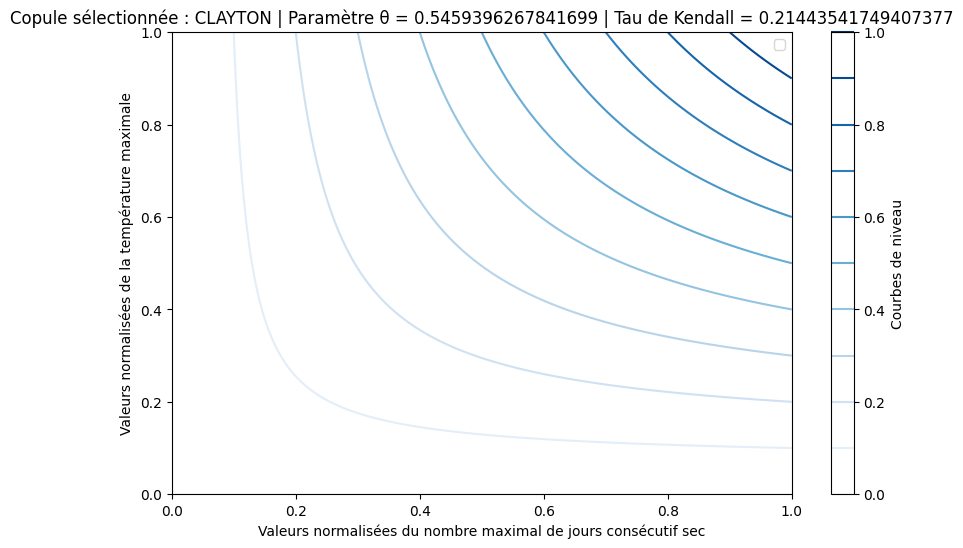

In [74]:
donnees = np.column_stack(
            (df_normalized.dry, df_normalized.hot)
        )
copule_selectionnee.fit(donnees)
u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U, V = np.meshgrid(u, v)
Z = copule_selectionnee.cumulative_distribution(
            np.column_stack((U.ravel(), V.ravel()))
        ).reshape(100, 100)

plt.figure(figsize=(10, 6))
contour = plt.contour(U, V, Z, levels=np.linspace(0, 1, 11), cmap="Blues")
cbar = plt.colorbar(contour)
cbar.set_label("Courbes de niveau")
# plt.scatter(
#            df_normalized.dry,
#             df_normalized.hot,
#             c="red",
#             label="Observations normalisées",
#             alpha=0.5,
#         )# Déterminer le contenu du titre dynamiquement
theta_display =theta
tau_display =kendall
titre = (
            f"Copule sélectionnée : {nom_copule} | "
            f"Paramètre θ = {theta_display} | "
            f"Tau de Kendall = {tau_display}"
        )

plt.title(titre)
plt.xlabel(f"Valeurs normalisées du nombre maximal de jours consécutif sec")
plt.ylabel(f"Valeurs normalisées de la température maximale")
plt.legend()
#plt.savefig(f"output/Copule_{self.nom_copule}_{self.nom_variable1}_{self.nom_variable2}.png")

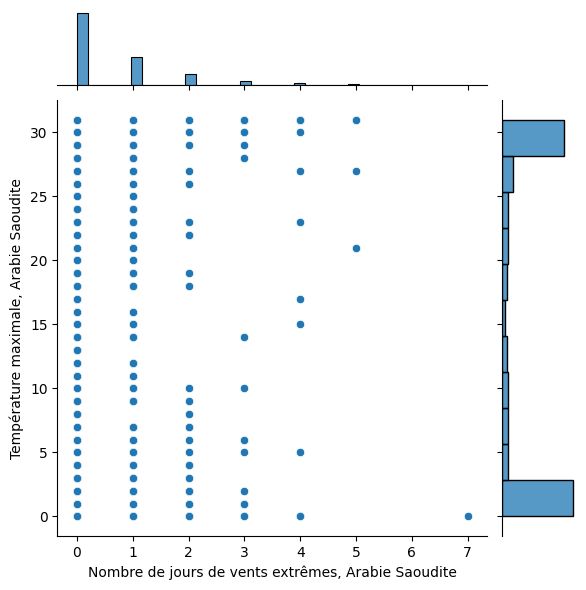

In [54]:
h = sns.jointplot(x=df.wind, y=df.hot, kind="scatter")
h.set_axis_labels(f"Nombre de jours de vents extrêmes, Arabie Saoudite", f"Température maximale, Arabie Saoudite", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


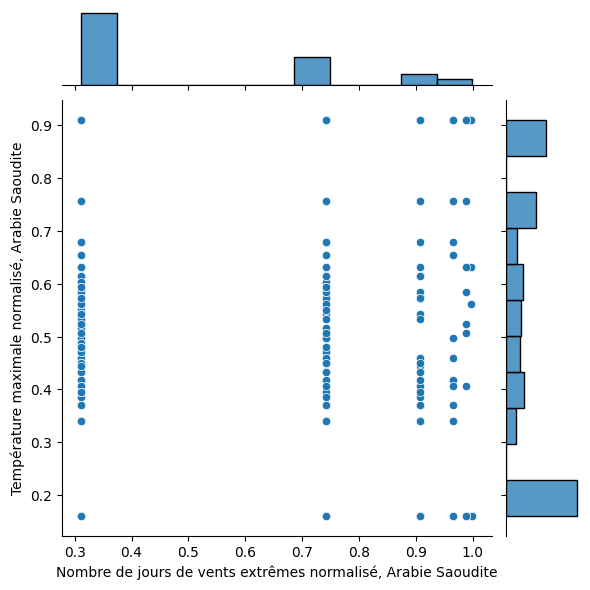

In [55]:
h = sns.jointplot(x=df_normalized.wind, y=df_normalized.hot, kind="scatter")
h.set_axis_labels(f"Nombre de jours de vents extrêmes normalisé, Arabie Saoudite", f"Température maximale normalisé, Arabie Saoudite", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


In [68]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["wind","hot"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
-0.02484718662599779
-0.012579880633920798


c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


C:\Users\lucas\AppData\Local\Temp\ipykernel_50872\3994022945.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


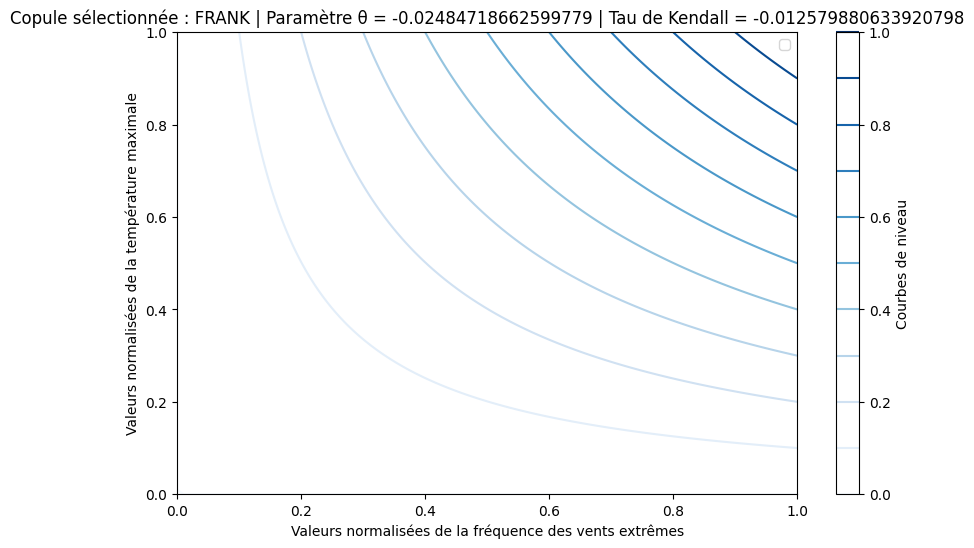

In [70]:
donnees = np.column_stack(
            (df_normalized.wind, df_normalized.hot)
        )
copule_selectionnee.fit(donnees)
u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U, V = np.meshgrid(u, v)
Z = copule_selectionnee.cumulative_distribution(
            np.column_stack((U.ravel(), V.ravel()))
        ).reshape(100, 100)

plt.figure(figsize=(10, 6))
contour = plt.contour(U, V, Z, levels=np.linspace(0, 1, 11), cmap="Blues")
cbar = plt.colorbar(contour)
cbar.set_label("Courbes de niveau")
# plt.scatter(
#            df_normalized.dry,
#             df_normalized.hot,
#             c="red",
#             label="Observations normalisées",
#             alpha=0.5,
#         )# Déterminer le contenu du titre dynamiquement
theta_display =theta
tau_display =kendall
titre = (
            f"Copule sélectionnée : {nom_copule} | "
            f"Paramètre θ = {theta_display} | "
            f"Tau de Kendall = {tau_display}"
        )

plt.title(titre)
plt.xlabel(f"Valeurs normalisées de la fréquence des vents extrêmes")
plt.ylabel(f"Valeurs normalisées de la température maximale")
plt.legend()
#plt.savefig(f"output/Copule_{self.nom_copule}_{self.nom_variable1}_{self.nom_variable2}.png")

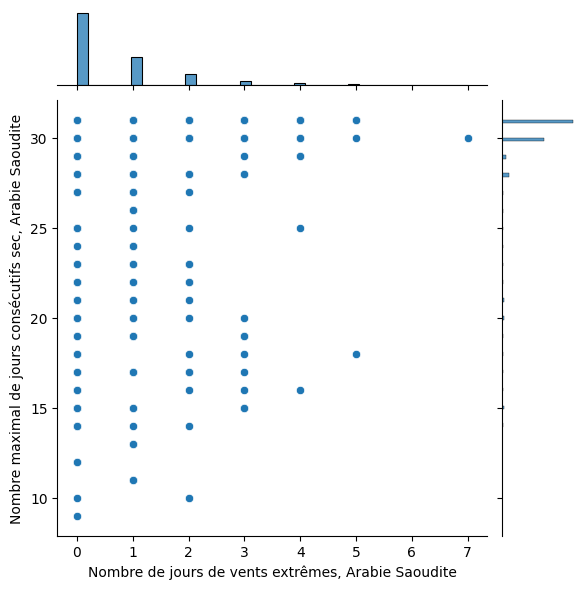

In [57]:
h = sns.jointplot(x=df.wind, y=df.dry, kind="scatter")
h.set_axis_labels(f"Nombre de jours de vents extrêmes, Arabie Saoudite", f"Nombre maximal de jours consécutifs sec, Arabie Saoudite", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


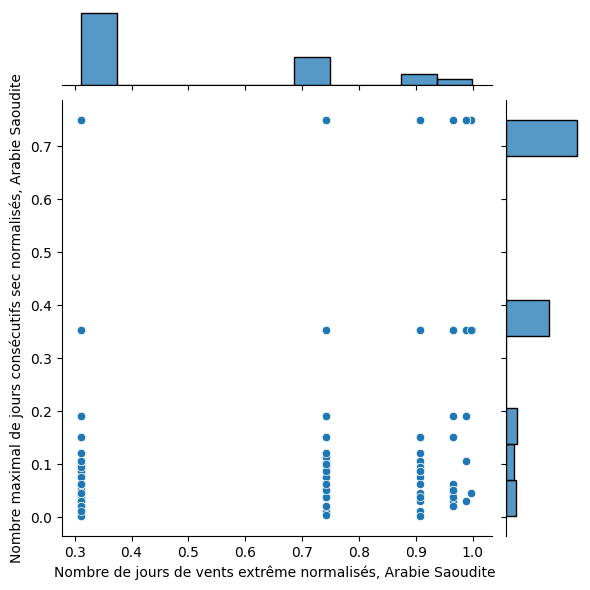

In [58]:
h = sns.jointplot(x=df_normalized.wind, y=df_normalized.dry, kind="scatter")
h.set_axis_labels(f"Nombre de jours de vents extrême normalisés, Arabie Saoudite ", f"Nombre maximal de jours consécutifs sec normalisés, Arabie Saoudite", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


In [76]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["wind","dry"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
-0.7011349732105635
-0.5398058757064578


c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


C:\Users\lucas\AppData\Local\Temp\ipykernel_50872\4080120254.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


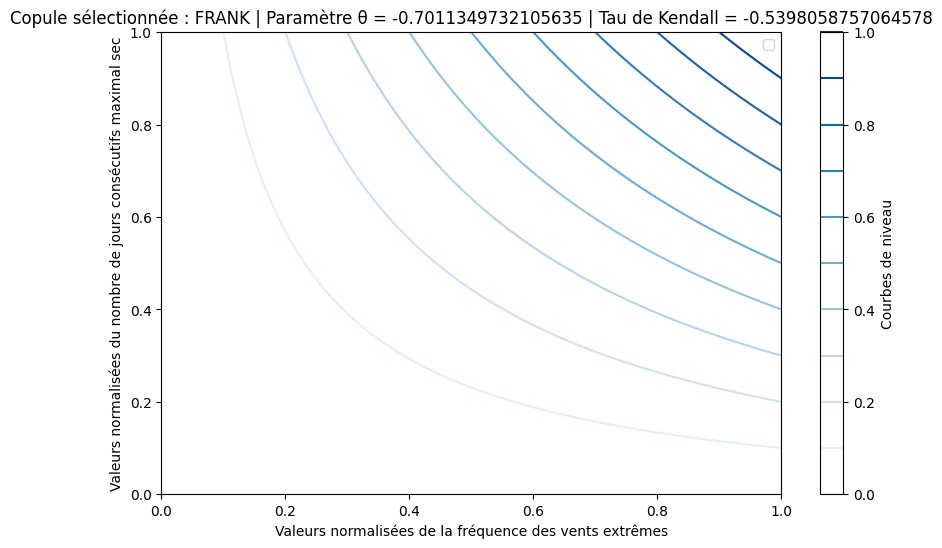

In [77]:
donnees = np.column_stack(
            (df_normalized.wind, df_normalized.dry)
        )
copule_selectionnee.fit(donnees)
u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U, V = np.meshgrid(u, v)
Z = copule_selectionnee.cumulative_distribution(
            np.column_stack((U.ravel(), V.ravel()))
        ).reshape(100, 100)

plt.figure(figsize=(10, 6))
contour = plt.contour(U, V, Z, levels=np.linspace(0, 1, 11), cmap="Blues")
cbar = plt.colorbar(contour)
cbar.set_label("Courbes de niveau")
# plt.scatter(
#            df_normalized.dry,
#             df_normalized.hot,
#             c="red",
#             label="Observations normalisées",
#             alpha=0.5,
#         )# Déterminer le contenu du titre dynamiquement
theta_display =theta
tau_display =kendall
titre = (
            f"Copule sélectionnée : {nom_copule} | "
            f"Paramètre θ = {theta_display} | "
            f"Tau de Kendall = {tau_display}"
        )

plt.title(titre)
plt.xlabel(f"Valeurs normalisées de la fréquence des vents extrêmes")
plt.ylabel(f"Valeurs normalisées du nombre de jours consécutifs maximal sec")
plt.legend()

# Copule multivarié

In [126]:

copula = VineCopula("center")
copula.fit(df_normalized)
synthetic_data = copula.sample(len(df_normalized))

c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\multivariate\vine.py:78: UserWarning:

Vines have not been fully tested on Python >= 3.8 and might produce wrong results.

c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning:

Data does not appear to be uniform.



In [127]:
copula_params = copula.to_dict()
copula_params.keys()

dict_keys(['type', 'vine_type', 'fitted', 'n_sample', 'n_var', 'depth', 'truncated', 'trees', 'tau_mat', 'u_matrix', 'unis', 'columns'])

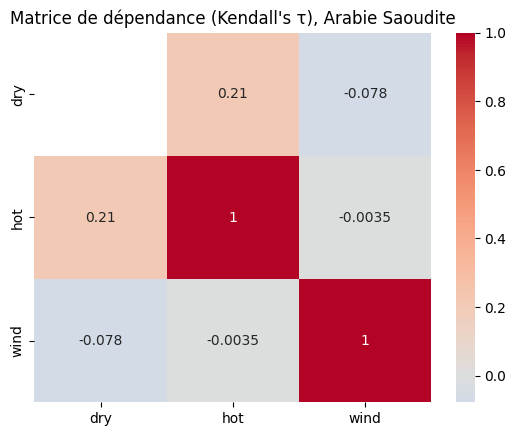

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tau_mat = np.array(copula_params['tau_mat'])
labels = ['dry', 'hot', 'wind']

sns.heatmap(tau_mat, annot=True, xticklabels=labels, yticklabels=labels, cmap='coolwarm', center=0)
plt.title("Matrice de dépendance (Kendall's τ), Arabie Saoudite")
plt.show()


In [129]:
copula_params['type']

'copulas.multivariate.vine.VineCopula'

In [ ]:
# scatter_3d(df.iloc[:,2:])
scatter_3d(df_normalized)

In [133]:

compare_3d(df_normalized, synthetic_data)